<a href="https://colab.research.google.com/github/amirhoseinoveis/GradCAM-with-MSTAR/blob/main/GradCAM_with_MSTAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:

import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib
import matplotlib.pyplot as plt
import os
from tensorflow.keras import losses, layers
import keras
from sklearn.metrics import classification_report,confusion_matrix
tf.random.set_seed(42)

In [79]:

github_url = 'https://raw.githubusercontent.com/amirhoseinoveis/LIME_with_MSTAR/7f0ea0868eec651540c373570060728392070ff5/mstar_3cl_32by32.npz'

# Download the file using wget
path = '/content/mstar_3cl_32by32.npz'
os.system(f'wget {github_url} -O {path}')

# Load the data using np.load
with np.load(path) as data_mstar:
    x_train_mstar = data_mstar['x_train']
    y_train_mstar = data_mstar['y_train']
    x_test_mstar = data_mstar['x_test']
    y_test_mstar = data_mstar['y_test']
x_train_mstar=np.concatenate([x_train_mstar,x_train_mstar,x_train_mstar],axis=-1)
x_test_mstar=np.concatenate([x_test_mstar,x_test_mstar,x_test_mstar],axis=-1)



In [80]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img =( jet_heatmap * alpha + img)
    superimposed_img/=superimposed_img.max()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM Heatmap')
    plt.imshow(heatmap, cmap='jet')

    plt.subplot(1, 3, 3)
    plt.title('Overlay of Grad-CAM')
    plt.imshow(superimposed_img)


In [81]:
inputs = Input(shape=(32,32,3),name="Input")
x = Conv2D(128, 3, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(32, 3, activation="relu",padding='same',name='Conv3')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Conv2D(16, 3, activation="relu",padding='same',name='Conv4')(x)
x = MaxPooling2D(2,name='Pool3')(x)

x = Flatten(name='Vectorize')(x)
outputs= Dense(3,name='FC',activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 32)          │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 8, 8, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Vectorize (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC (Dense)                           │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,875 (179.20 KB)

 Trainable params: 45,875 (179.20 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:


hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on',
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - acc: 0.4134 - loss: 1.0523 - val_acc: 0.5619 - val_loss: 0.8975
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - acc: 0.6427 - loss: 0.8138 - val_acc: 0.7143 - val_loss: 0.6171
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - acc: 0.7543 - loss: 0.6065 - val_acc: 0.8095 - val_loss: 0.4677
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - acc: 0.8387 - loss: 0.4404 - val_acc: 0.8476 - val_loss: 0.3773
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - acc: 0.9015 - loss: 0.3046 - val_acc: 0.8952 - val_loss: 0.2918
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - acc: 0.9500 - loss: 0.1919 - val_acc: 0.9238 - val_loss: 0.1920
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - acc: 0.9718 - loss: 0.1126 - val_acc: 0.9429 - val_loss: 0.1665
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - acc: 0.9786 - loss: 0.0804 - val_acc: 0.9905 - val_loss: 0.1091
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - ac

In [83]:
classes_in=[0,1,2]
y_hat=model.predict(x_test_mstar)#test the model, prob.


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [84]:
#classification_report
CM=confusion_matrix(y_true=y_test_mstar,y_pred=y_hat.argmax(1))
# Display confusion matrix
print("Confusion Matrix:")
print(CM)
print("classification_report:")

print(classification_report(y_true=y_test_mstar,y_pred=y_hat.argmax(1)))

Confusion Matrix:
[[272   2   0]
 [  1 273   0]
 [  0   2 272]]
classification_report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       274
           1       0.99      1.00      0.99       274
           2       1.00      0.99      1.00       274

    accuracy                           0.99       822
   macro avg       0.99      0.99      0.99       822
weighted avg       0.99      0.99      0.99       822



[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


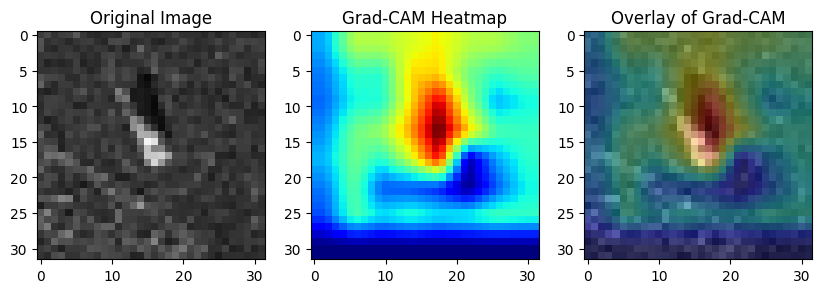

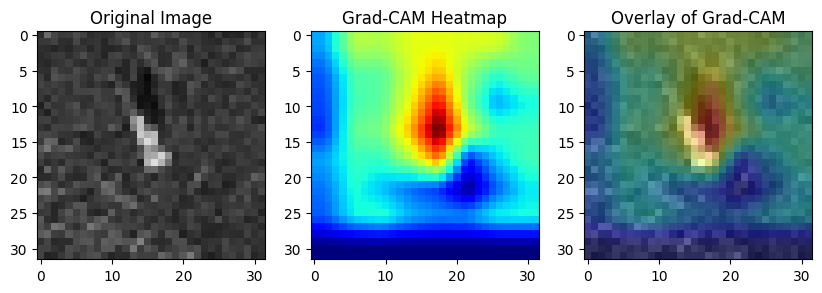

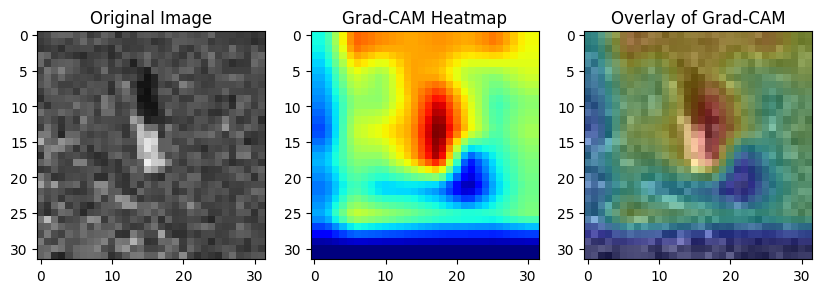

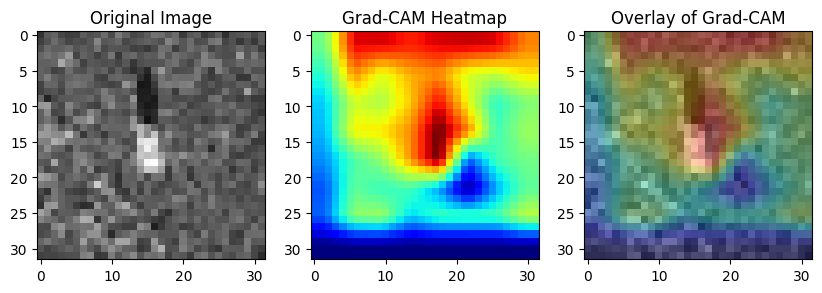

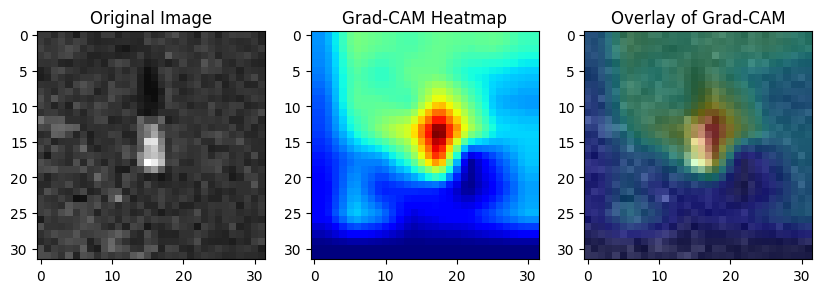

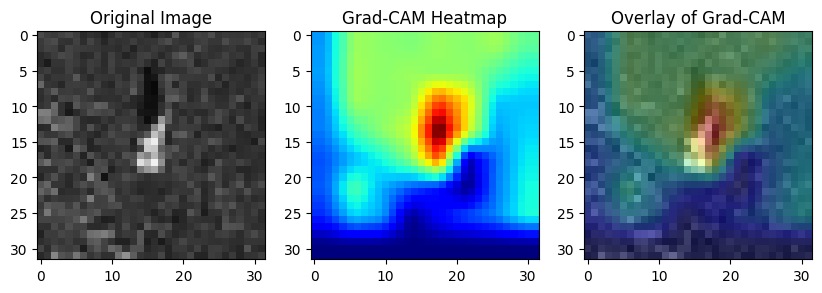

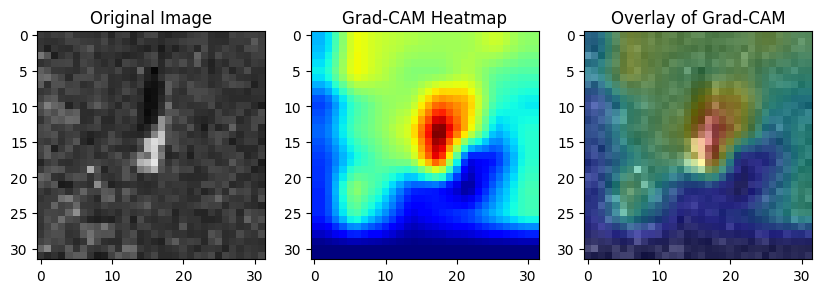

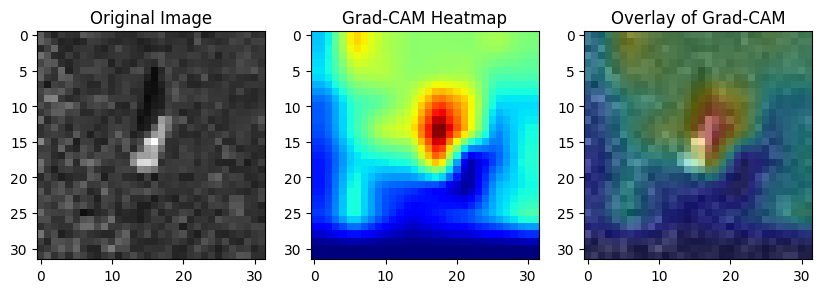

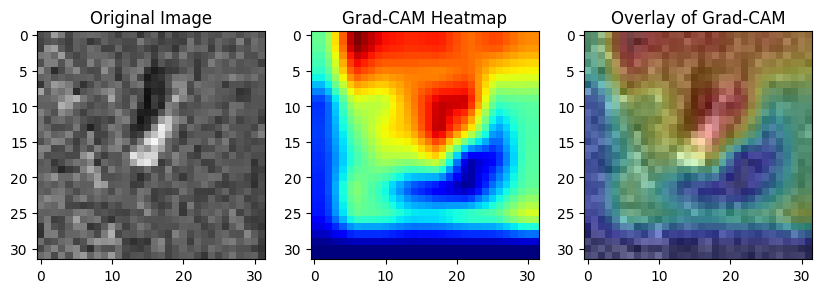

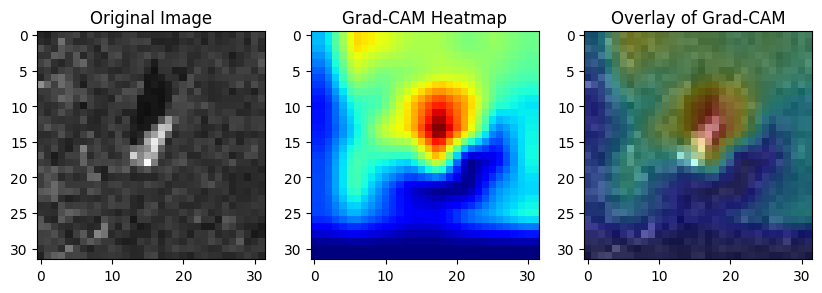

In [87]:
x_test=np.copy(x_test_mstar)
image_size=(32,32)

model.layers[-1].activation = None
for i in range(0,10,1) :

    img_array=x_test[i:i+1]
    print(y_test_mstar[i:i+1])
    #preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name= "Conv4")

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], image_size)
    heatmap = tf.squeeze(heatmap).numpy()



    save_and_display_gradcam(np.squeeze(np.uint8(255 *  img_array)), heatmap)


In [86]:
img_array.min()

0.0196078431372549